In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from scipy import sparse
from numpy import count_nonzero
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import joblib
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Carregando a base de treino
missing_value_formats = ["n.a.", "?", "NA", "n/a", "na", "--"]
dados = pd.read_csv('/content/data.csv', na_values = missing_value_formats)

In [3]:
# Observando
dados.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [4]:
# Observando numero de linhas e colunas
dados.shape

(944, 10)

In [5]:
# Informações dos tipos de variáveis
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB


In [6]:
# Informações estatísticas
dados.describe()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00
mean,306.38,3.73,4.33,2.94,5.39,2.84,47.04,4.57,16.33,0.42
std,1082.61,2.68,1.44,1.38,1.27,2.27,16.42,1.60,5.97,0.49
min,0.00,0.00,1.00,1.00,1.00,0.00,19.00,1.00,1.00,0.00
25%,1.00,1.00,3.00,2.00,5.00,1.00,34.00,3.00,14.00,0.00
50%,22.00,3.00,4.00,3.00,6.00,2.00,44.00,4.00,17.00,0.00
75%,110.00,7.00,6.00,4.00,6.00,5.00,58.00,6.00,21.00,1.00
max,7300.00,7.00,7.00,7.00,7.00,6.00,91.00,7.00,24.00,1.00


In [7]:
# Observando a existência de valores nulos
dados.isnull().sum().sum()

0

In [8]:
# Observando valores duplicados
dados.duplicated().sum()

1

In [9]:
# Excluindo dados duplicados
dados = dados.drop_duplicates()

In [10]:
# Conferindo
dados.duplicated().sum()

0

In [11]:
dados.shape

(943, 10)

In [12]:
# Calculando a dispersão dos dados
sparsity = 1 - count_nonzero(dados) / dados.size
print("A dispersão do dataframe é: " + str(round(sparsity, 2)) + ".")

A dispersão do dataframe é: 0.12.


In [13]:
# Confirmando
sparse.issparse(dados)

False

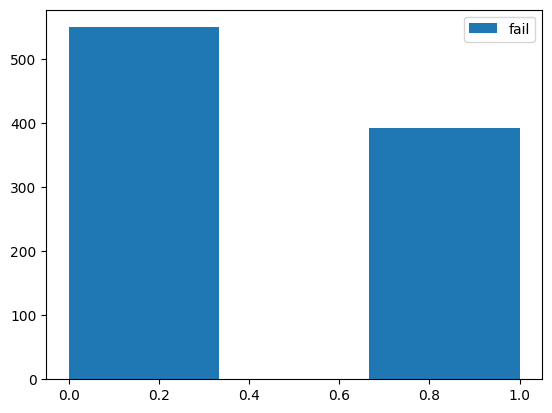

In [14]:
# Observando graficamente a variável target
dados["fail"].hist(grid = False, xlabelsize = 10, ylabelsize = 10, legend = "fail", bins = 3);

<Axes: ylabel='count'>

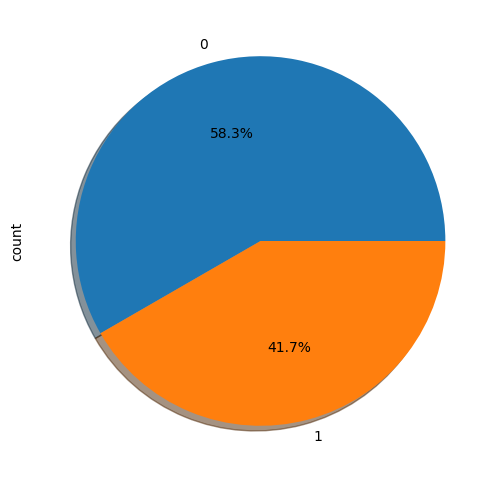

In [15]:
# Observando a porcentagem de falhas
plt.figure(figsize=(8,6))
dados['fail'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)

In [16]:
# Distribuição das variáveis
fig = make_subplots(rows=5, cols=2, subplot_titles=dados.columns)
for i, column in enumerate(dados.columns):
    row = i // 2 + 1
    col = i % 2 + 1
    hist = px.histogram(dados, x=column, template='plotly_dark', color_discrete_sequence=['#00FF00'])
    hist.update_traces(marker_line_width=0.5, marker_line_color="white")
    fig.add_trace(hist.data[0], row=row, col=col)

fig.update_layout(height=1200, title_text="Distribuição das variáveis numéricas", title_font=dict(size=25), title_x=0.5, showlegend=False)
fig.show()

In [17]:
# Matriz de correlação
corr = dados.corr()
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=corr.round(2).values,
    showscale=True,
    colorscale='Viridis')
fig.update_layout(title_text='Correlation Heatmap', title_font=dict(size=25), title_x=0.5)
fig.show()

In [18]:
# Carregando variaveis numéricas para plot
variaveis_numericas = []
for i in dados.columns[0:11].tolist():
        if dados.dtypes[i] == 'int64' or dados.dtypes[i] == 'float64':
            variaveis_numericas.append(i)

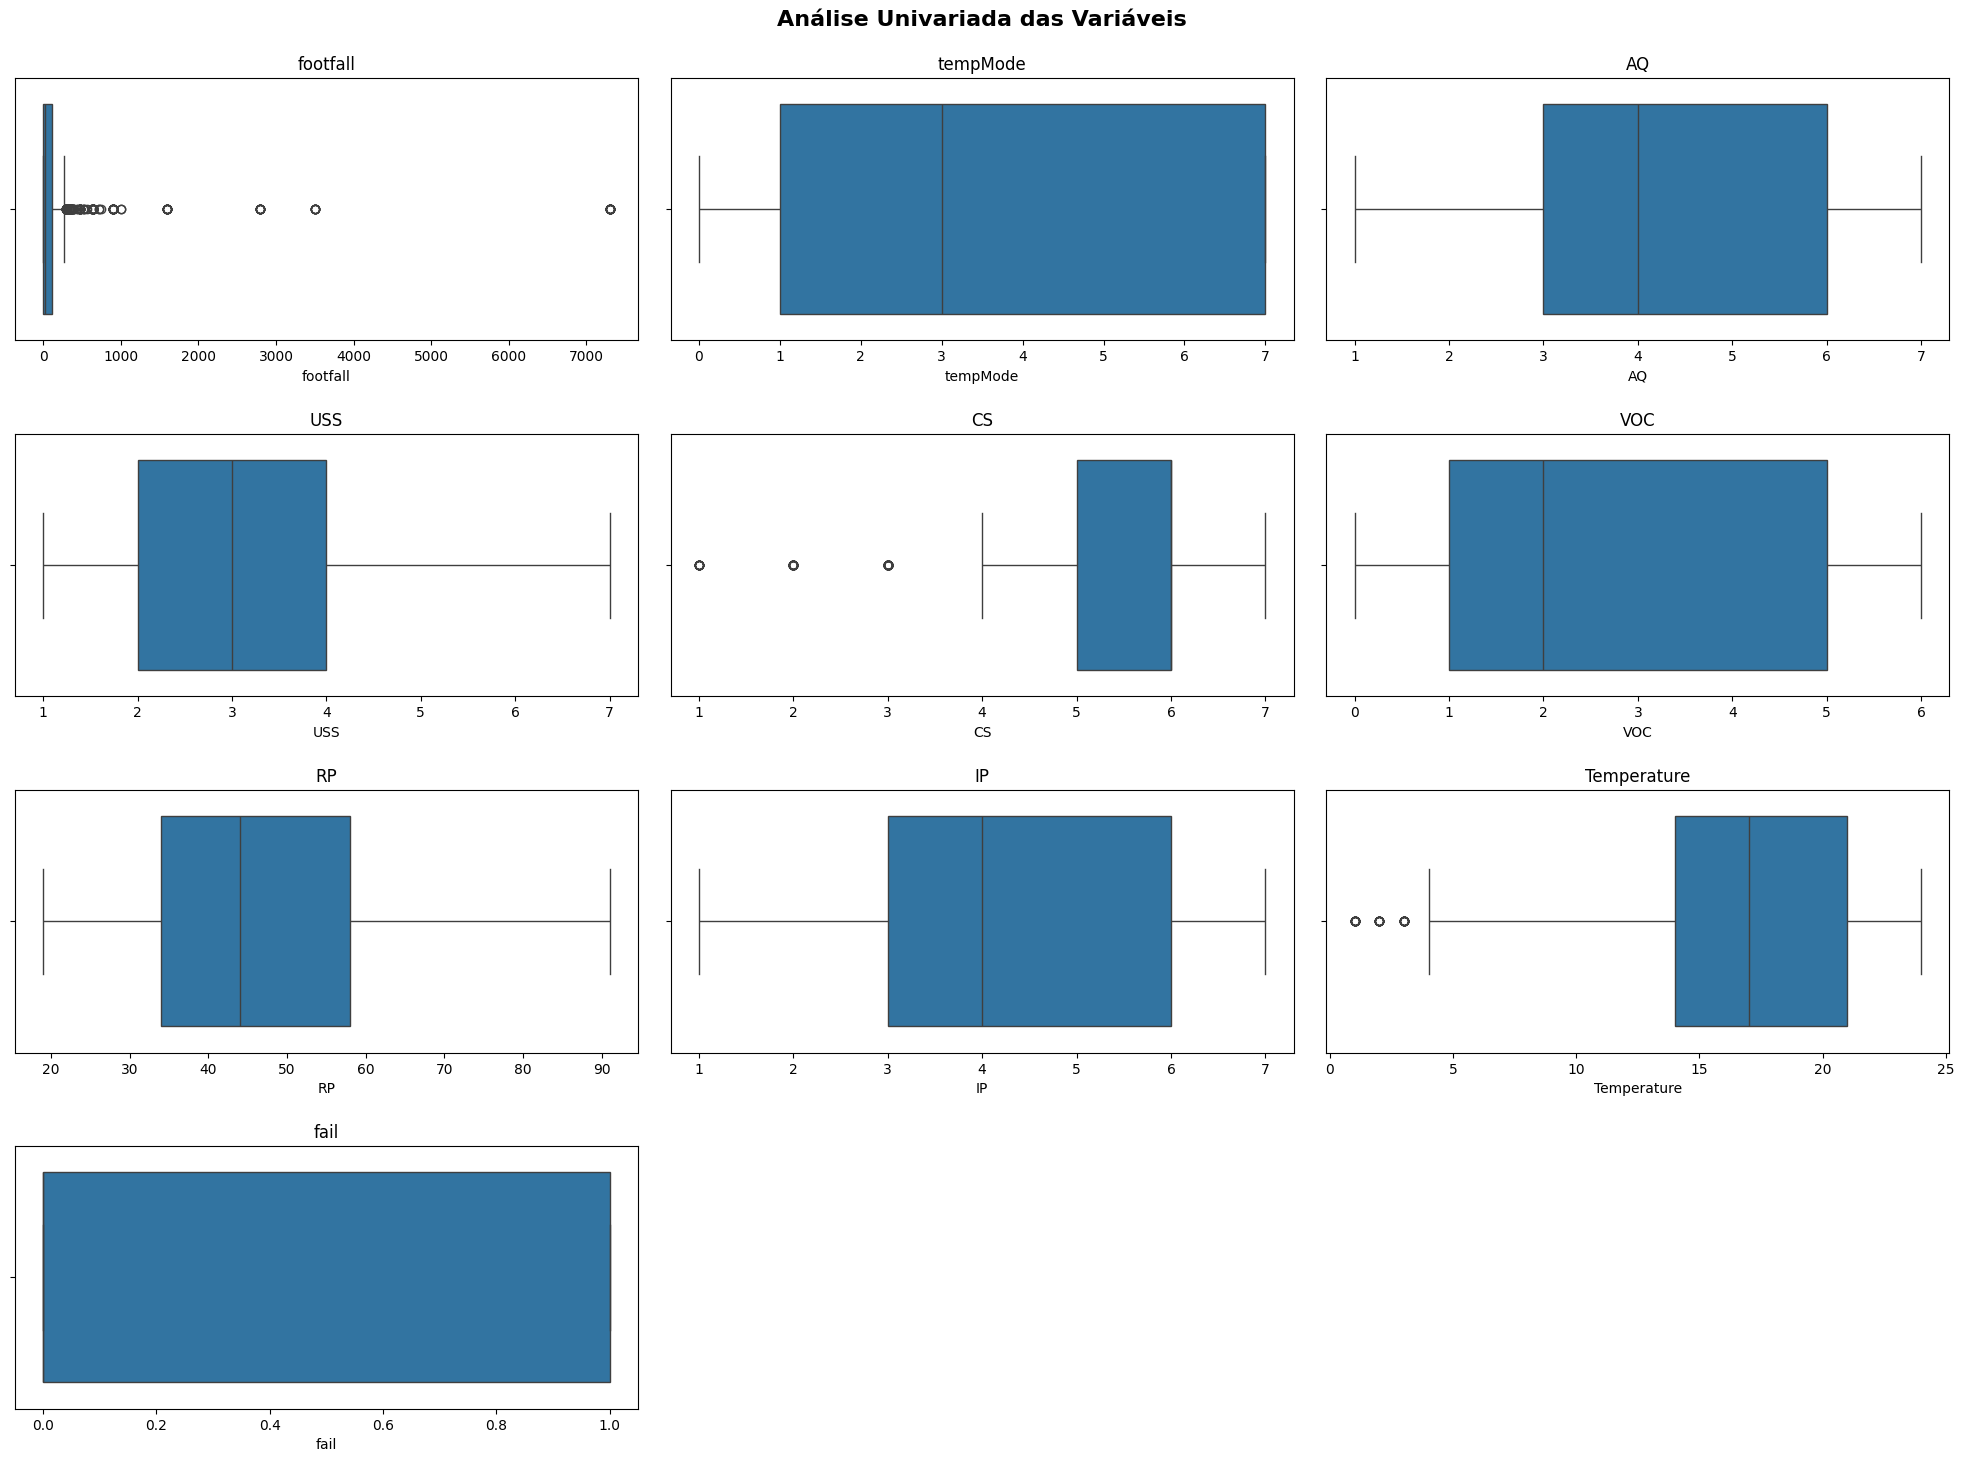

In [19]:
# Carregando boxplot para observar existência de outliers
plt.figure(figsize=(20, 15))
plt.suptitle("Análise Univariada das Variáveis", fontsize=16, fontweight='bold')

# Loop pelas variáveis numéricas e cria boxplots
for i in range(len(variaveis_numericas)):
    plt.subplot((len(variaveis_numericas) + 2) // 3, 3, i + 1)
    sns.boxplot(x=dados[variaveis_numericas[i]])
    plt.title(variaveis_numericas[i])
    plt.tight_layout(pad=2.0)

plt.show()

In [20]:
# Função para tratar os outliers
def remover_outlier(in_data,in_col):

    primeiro_quartil = in_data[in_col].quantile(0.25)
    terceiro_quartil = in_data[in_col].quantile(0.75)
    iqr = terceiro_quartil - primeiro_quartil
    sup_limit = terceiro_quartil + 1.5 * iqr
    inf_limit = primeiro_quartil - 1.5 * iqr
    in_data.loc[(in_data[in_col]>sup_limit), in_col] = sup_limit
    in_data.loc[(in_data[in_col]<inf_limit), in_col] = inf_limit
    return in_data

In [21]:
# Removendo
for i in variaveis_numericas:
    dados = remover_outlier(dados, i)

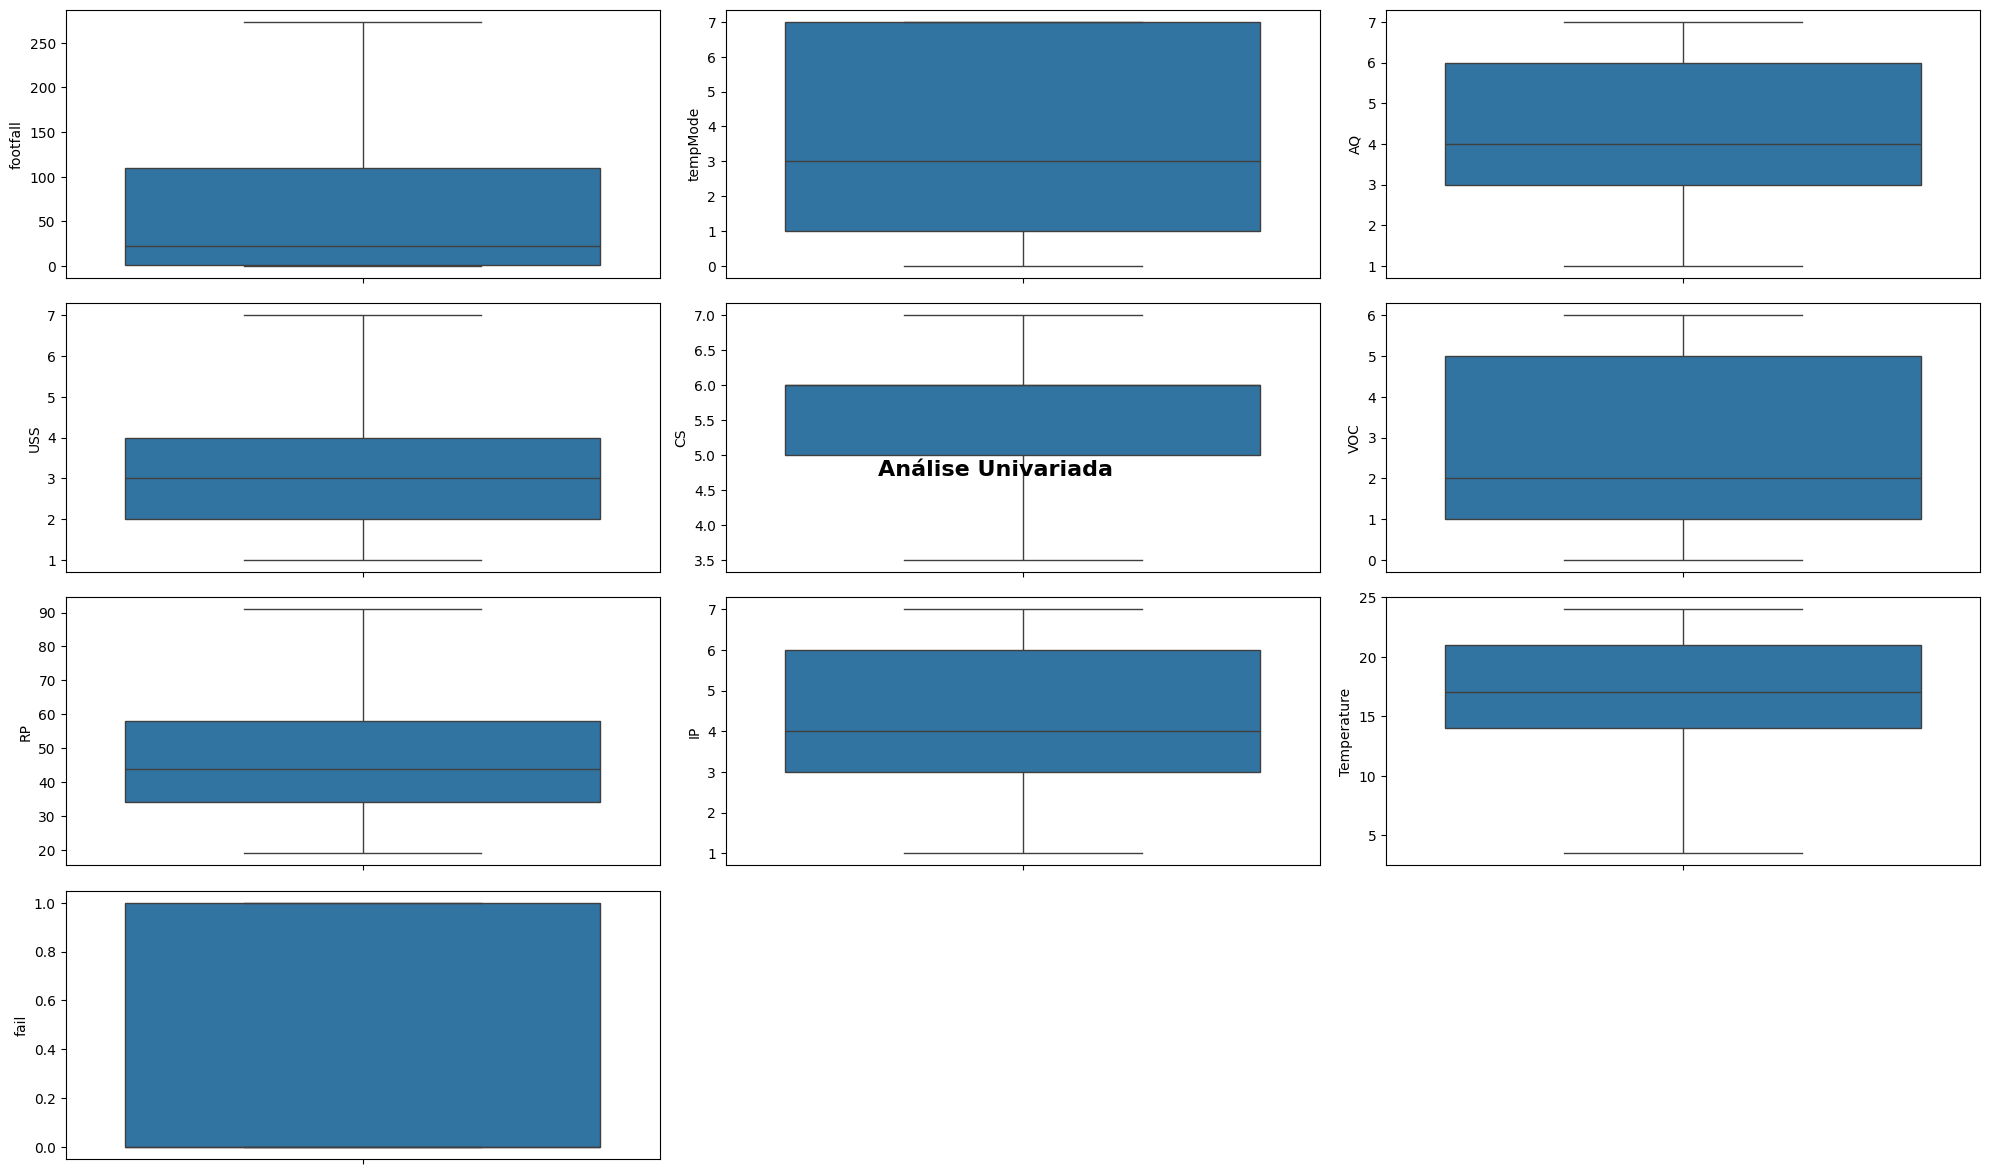

In [22]:
# Conferindo se os outliers foram removidos
plt.figure(figsize=(20,250))
plt.suptitle("Análise Univariada", fontsize=16, fontweight='bold')

for i in range(0,len(variaveis_numericas)):
    plt.subplot(85,3,i+1)
    sns.boxplot(dados[variaveis_numericas[i]])
    plt.tight_layout()

In [23]:
# Criando a variável target
target = dados['fail']

In [24]:
# Dropando a variável que não serve
preditoras = dados.drop(['fail'], axis=1)

In [25]:
target.head()

0   1.00
1   0.00
2   0.00
3   0.00
4   0.00
Name: fail, dtype: float64

In [26]:
preditoras.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature
0,0.00,7,7.00,1,6.00,6,36,3.00,3.50
1,190.00,1,3.00,3,5.00,1,20,4.00,3.50
2,31.00,7,2.00,2,6.00,1,24,6.00,3.50
3,83.00,4,3.00,4,5.00,1,28,6.00,3.50
4,273.50,7,5.00,6,4.00,0,68,6.00,3.50


In [27]:
target.shape

(943,)

In [28]:
preditoras.shape

(943, 9)

In [29]:
# Criando o balanceador SMOTE
from imblearn.over_sampling import SMOTE
balanceador = SMOTE()

In [30]:
# Aplicando o balanceador
preditoras_res, target_res = balanceador.fit_resample(preditoras, target)

In [31]:
# Observando se a variável target foi balanceada
target_res.value_counts()

fail
1.00    550
0.00    550
Name: count, dtype: int64

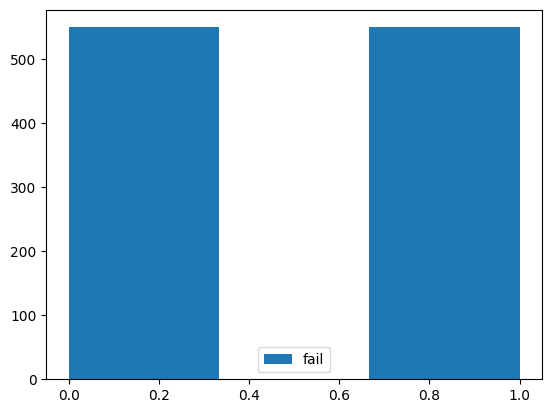

In [32]:
# Observando graficamente
target_res.hist(grid = False, xlabelsize = 10, ylabelsize = 10, legend = "class", bins = 3);

In [33]:
# Quantidade de registros após do balanceamento
preditoras_res.shape

(1100, 9)

In [34]:
# Quantidade de registros após do balanceamento
target_res.shape

(1100,)

In [35]:
# Divisão em Dados de Treino e Teste.
x_treino, x_teste, y_treino, y_teste = train_test_split(preditoras_res, target_res, test_size = 0.20)

In [36]:
# Padronização das Variáveis
padronizador = StandardScaler()
x_treino_padronizado = padronizador.fit_transform(x_treino)
x_teste_padronizado = padronizador.transform(x_teste)

In [37]:
# Visualizando os dados padronizados
x_treino_padronizado

array([[ 0.59008246,  1.24400129, -0.30704704, ...,  0.6368285 ,
        -1.03173716, -2.27712245],
       [-0.7400415 , -1.40757239, -0.30704704, ..., -1.39971583,
        -0.38938384,  0.06691142],
       [-0.57196922,  0.86520505,  0.96703815, ...,  0.33733669,
         0.75831311,  1.10870425],
       ...,
       [-0.7400415 ,  1.24400129,  1.1191358 , ...,  1.29571049,
        -1.03173716, -0.10672072],
       [-0.5149436 ,  1.24400129, -1.02013847, ..., -0.02205349,
        -1.03173716, -0.28035286],
       [-0.22845536,  0.10761257, -1.02013847, ..., -0.20174858,
        -1.03173716,  0.58780784]])

In [38]:
modelos = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(probability=True)
}

params = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10]},
    'SVM': {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

In [39]:
best_models = {}
best_accuracy = 0
best_model_name = ''
best_model = None

for model_name in modelos.keys():
    grid = GridSearchCV(modelos[model_name], params[model_name], cv=5, n_jobs=-1, verbose=1)
    grid.fit(x_treino_padronizado, y_treino)
    best_models[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(x_teste_padronizado)
    accuracy = accuracy_score(y_teste, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        best_model = grid.best_estimator_

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 200}
Accuracy for RandomForest: 0.9272727272727272
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 50}
Accuracy for GradientBoosting: 0.9227272727272727
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for LogisticRegression: {'C': 1}
Accuracy for LogisticRegression: 0.9227272727272727
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Accuracy for SVM: 0.9363636363636364

Best model: SVM with accuracy: 0.9363636363636364


In [40]:
# Observando a acurácia do modelo
y_pred = best_model.predict(x_teste_padronizado)
print(accuracy_score(y_teste, y_pred)*100)

93.63636363636364


In [41]:
y_pred

array([1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.])

In [42]:
y_teste

128    1.00
65     0.00
366    1.00
842    0.00
496    0.00
94     0.00
726    1.00
1077   1.00
447    1.00
481    0.00
975    1.00
278    1.00
722    1.00
710    1.00
672    0.00
212    1.00
485    0.00
188    0.00
266    0.00
542    1.00
319    0.00
960    1.00
112    0.00
593    0.00
1086   1.00
289    1.00
890    0.00
908    1.00
516    1.00
306    0.00
451    1.00
646    0.00
986    1.00
1008   1.00
441    0.00
119    0.00
125    0.00
215    1.00
641    1.00
501    1.00
173    1.00
204    1.00
430    0.00
597    0.00
980    1.00
237    0.00
873    0.00
163    1.00
367    1.00
772    0.00
71     0.00
348    1.00
1099   1.00
629    0.00
93     1.00
1085   1.00
969    1.00
209    0.00
432    0.00
559    0.00
194    1.00
974    1.00
1049   1.00
874    0.00
352    1.00
1      0.00
910    0.00
1033   1.00
688    0.00
493    1.00
482    1.00
530    0.00
167    0.00
557    1.00
661    0.00
568    0.00
640    1.00
580    1.00
338    1.00
1066   1.00
181    0.00
814    0.00
92     1.00
695 

In [43]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       113
         1.0       0.92      0.95      0.94       107

    accuracy                           0.94       220
   macro avg       0.94      0.94      0.94       220
weighted avg       0.94      0.94      0.94       220



In [44]:
cm = confusion_matrix(y_teste, y_pred)
print(cm)

[[104   9]
 [  5 102]]


In [45]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Não","Sim"])

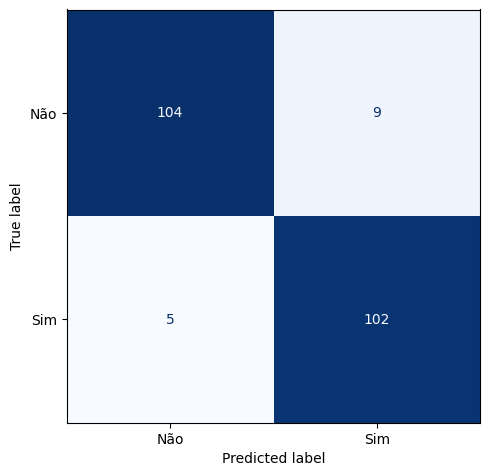

In [46]:
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
cm_disp.plot(include_values=True,
             cmap='Blues',
             colorbar=None)